<h2>PyTorch of a CNN model: test and evaluate the test set developed in lab 7<br></h2>

Trained using the MNIST dataset

Tested using the idata2 dataset


In [19]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
    
import numpy as np
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import pandas as pd
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class SimpleDataset(Dataset):
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Transforms
        self.transform = transform
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1],dtype = np.uint8)

        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = Image.open(self.data_path + single_image_name)
        if self.transform is not None:
              img_as_img = self.transform(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        #convert to tensor to be consistent with MNIST dataset
        single_image_label = torch.LongTensor( [ single_image_label ] )[0]
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

mydataT = SimpleDataset( "./idata2/", "labels111.csv", transform=transforms.ToTensor())
len(mydataT)

60

In [20]:
#load MNIST dataset
import time
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

#idata2 dataset
test_dataset = mydataT

# Utilities
These functions provide Learning curve plots and learning progress reports 

In [21]:
'''Learning Curve Plot Utility'''
def plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
  fig, axs = plt.subplots(1, 2, figsize=(11,5))

  ax = axs[0]
  ax.set_title("Model Loss", fontsize=12)
  ax.plot(train_loss_history, label="Training")
  ax.plot(val_loss_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Average loss", fontsize=12)
  ax.legend(loc="best",         fontsize=12)

  ax = axs[1]
  ax.set_title("Model Accuracy", fontsize=12)
  ax.plot(train_acc_history, label="Training")
  ax.plot(val_acc_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Accuracy",     fontsize=12)
  ax.set_ylim(0,1)
  ax.legend(loc="best",         fontsize=12)

In [22]:
'''Learning progress utility'''
def log_progress(running_loss, curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}]. Running Loss: {} Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(running_loss, 2), round(progress * 100, 2))
    print(log)

In [23]:
#  preserntation for a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


<h3> Hyperparameters </h3>

In [24]:
# Hyperparameters
num_epochs = 6
num_classes = 11
batch_size = 100
learning_rate = 0.0001

<h3> Data Loader</h3>

In [25]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## Model P2


In [26]:
# Model
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Training 

In [27]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):
    
    # Place network in training mode
    model.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(train_loader):
        # [inputs] and [labels] is one batch of images and their classes
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics for this batch
        curr_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        curr_images = labels.cpu().data.numpy().size
        curr_correct = torch.sum(preds == labels.data.reshape(-1))

        # Update running statistics for this epoch
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

    # Update statistics for epoch
    train_loss_history[epoch] = curr_loss #running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
        round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    model.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Propagate batch through network
        outputs  = model(inputs)
        loss     = criterion(outputs, labels.squeeze())
        _, preds = torch.max(outputs, 1)
        
        # Update statistics for this batch
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.cpu().data.numpy().size
        
        # Log Progress every 200 batches
        if (batch_num + 1) % 200 == 0:
          log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)    

    # Update statistics for validation data
    val_loss_history[epoch] = loss.item() #running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

EPOCH [1/6]. Running Loss: 189.3 Progress: 33.33 % 
EPOCH [1/6]. Running Loss: 243.98 Progress: 66.67 % 
EPOCH [1/6]. Running Loss: 279.89 Progress: 100.0 % 
Train Avg. Loss: [0.1127] Acc: 0.894 on 60000.0 images
Validating...
Val Avg. Loss: [2.186] Acc: 0.7166666666666667 on 60.0 images

EPOCH [2/6]. Running Loss: 26.17 Progress: 33.33 % 
EPOCH [2/6]. Running Loss: 48.75 Progress: 66.67 % 
EPOCH [2/6]. Running Loss: 68.59 Progress: 100.0 % 
Train Avg. Loss: [0.0793] Acc: 0.9712 on 60000.0 images
Validating...
Val Avg. Loss: [2.3307] Acc: 0.7666666666666667 on 60.0 images

EPOCH [3/6]. Running Loss: 17.4 Progress: 33.33 % 
EPOCH [3/6]. Running Loss: 32.37 Progress: 66.67 % 
EPOCH [3/6]. Running Loss: 46.47 Progress: 100.0 % 
Train Avg. Loss: [0.0716] Acc: 0.9795 on 60000.0 images
Validating...
Val Avg. Loss: [2.4451] Acc: 0.7666666666666667 on 60.0 images

EPOCH [4/6]. Running Loss: 12.48 Progress: 33.33 % 
EPOCH [4/6]. Running Loss: 24.51 Progress: 66.67 % 
EPOCH [4/6]. Running Loss: 

## Learning curve plots

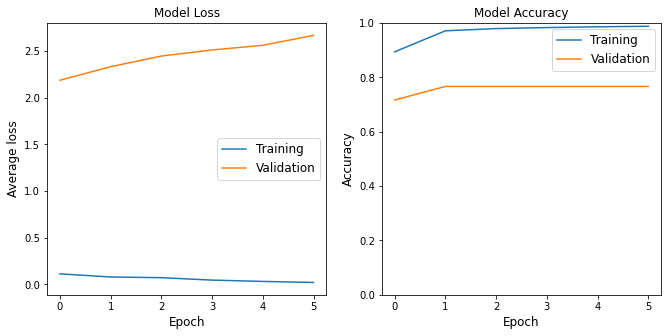

In [28]:
plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

<h2> Testing </h2>

In [31]:
# Test the model
start_time = datetime.now()
ytest = []
rtest = np.ones((0,11))
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        ytest = np.append(ytest, labels)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        rtest = np.append(rtest, outputs, axis=0)
print('Test Accuracy of the model on the 60 test images: {} %'.format(100 * correct / total))
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

Test Accuracy of the model on the 60 test images: 76.66666666666667 %
Time Elapsed: 0.043089 seconds


Confusion matrix, without normalization


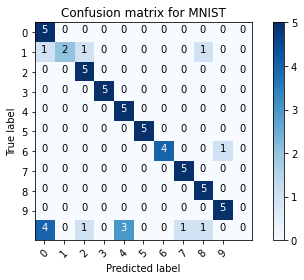

In [32]:
cfm = confusion_matrix(ytest, np.argmax (rtest,axis=1))
plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for MNIST')

In [33]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')